In [89]:
import pandas as pd 
import numpy as np

# visualization
import plotly.express as px 
import seaborn as sns 
import matplotlib.pyplot as plt

# learning models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# transform
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV

In [50]:
df_train = pd.read_csv('/home/ymsa/Desktop/home_work_ml/homework2/part2_dz3/dataset/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/home/ymsa/Desktop/home_work_ml/homework2/part2_dz3/dataset/house-prices-advanced-regression-techniques/test.csv')

In [51]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


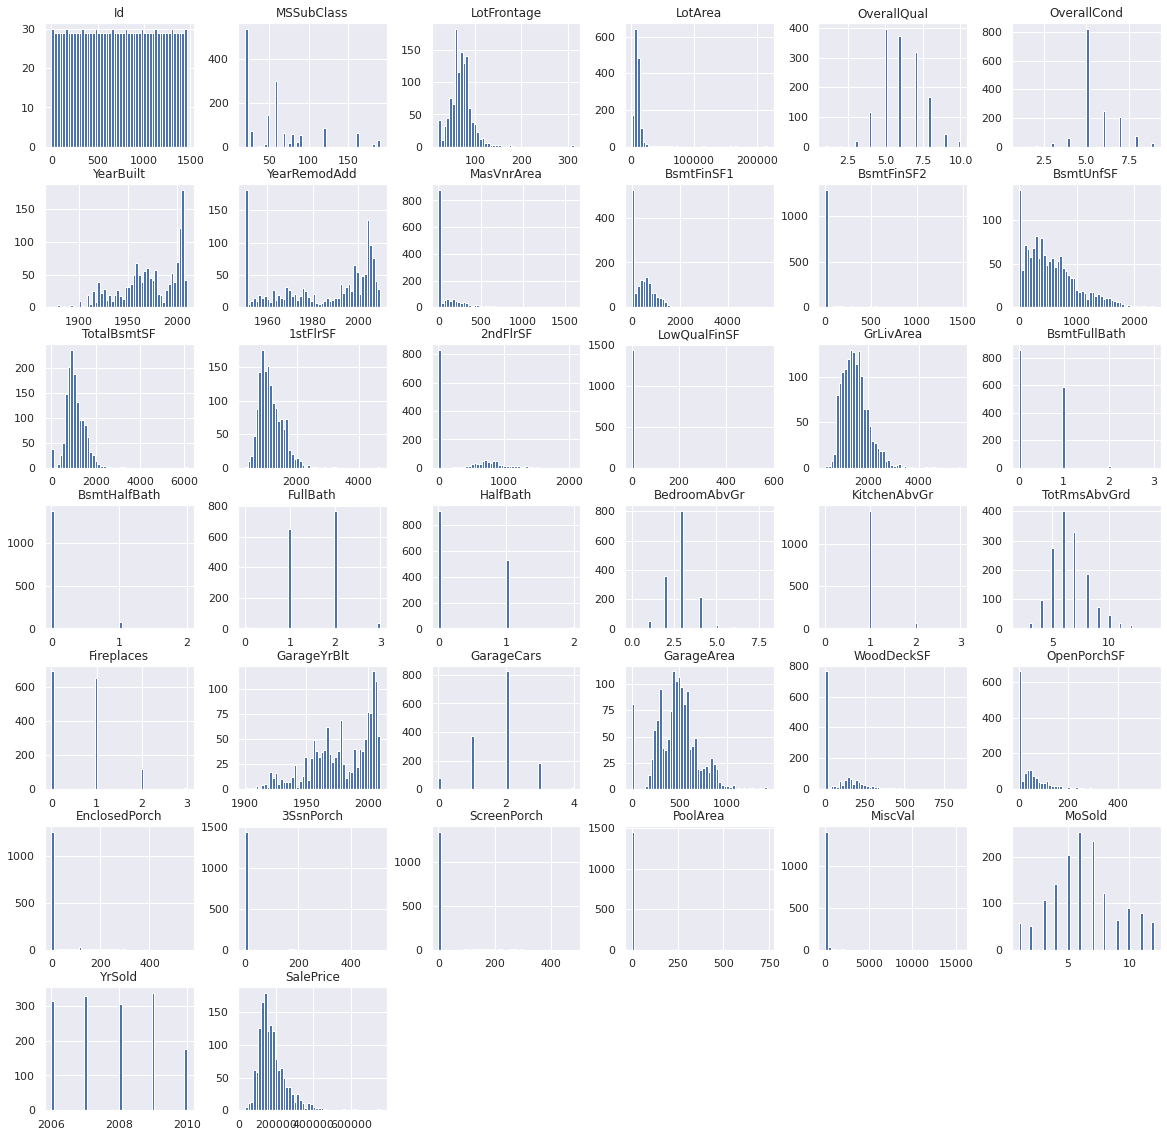

In [52]:
df_train.hist(bins=50, figsize=(20,20))
plt.show()

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Преобразования

**В обучающей и тестовой выборке видно, что есть столбцы с пропущенными данными и количество пропущеных данных состовлят от 70% - 90%, поэтому целлесобразнее будет удалить эти данные.**

**Для болле удобной работы конкатенируем 2 таблицы, при этом мы должны отметить каждую таблицу для последущего разьединиение**

In [54]:
df_train['is_test'] = 0
df_test['is_test'] = 1

In [55]:
df = pd.concat([df_train, df_test])

**Удалим столбцы с пропущенными данными у которых отсудствует больше половины значений**

In [56]:
df.drop(axis=1, columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True)

In [57]:
train = df[df.is_test==0].drop('is_test', axis=1)
test = df[df.is_test==1].drop('is_test', axis=1)

**Построим матрицу корреляции столбцов**

In [58]:
corr_matrix = train.corr()

In [59]:
corr_matrix.SalePrice.sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

**Возьмем первые 6 столбцов, а так же такие категориалные параметры такие как Electrical, Street, Utilities, потому что:**

**```Electrical```** - **Электрическая система**

**```Street```**  - **Тип подъезда к дому**

**```Utilities```** - **Какие коммуникации подведены к дому**

**Эти параметры очень важны в оценки стоимости дома, почему они не как не отображаются в таблице корреляции? Все просто потому что это категориальные столбцы**


In [60]:
train_new = train[['SalePrice', 'OverallQual',      
                    'GrLivArea', 'GarageCars',       
                    'GarageArea', 'TotalBsmtSF',               
                    'YearBuilt', 'LotArea', 
                    'PoolArea','Utilities', 
                    'Electrical', 'Street']]

In [61]:
test_new = test[['Id', 'OverallQual',      
                'GrLivArea', 'GarageCars',       
                'GarageArea', 'TotalBsmtSF',               
                'YearBuilt', 'LotArea', 
                'PoolArea','Utilities', 
                'Electrical', 'Street']]

<AxesSubplot:>

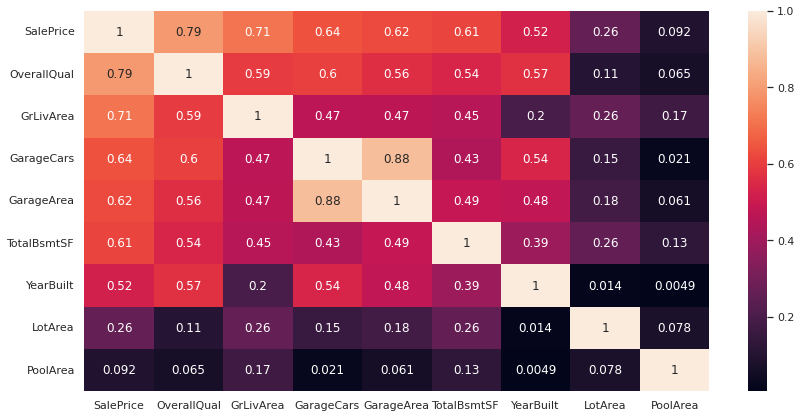

In [62]:
new_corr = train_new.corr()
sns.set(rc = {'figure.figsize':(14,7)})
sns.heatmap(new_corr, annot=True)

**С графика линейной корреляции видно, что с основным показателем, а именно с**

**```SalePrice(стоимость продажи)```** которая линейно коррелирует с такими показателями:

**```OverallQual(Оценка состояния дома и материалов дома)```**

**```GrLivArea(площадь земли в кв. футах)```**

**```GarageCars(Размер гаража)```**

**```GarageArea(Площадь гаража)```**

**Последнии 2 параметра, а иммено GarageCars и GarageArea обозначают размер гаража в той или иной мере,
по этому будет лучше сложить эти параметры вместе и назвать общей гаражной площадью**

In [63]:
test_new["GrAreaPerCars"] = test_new["GarageCars"] + test_new["GarageArea"]
train_new["GrAreaPerCars"] = train_new["GarageCars"] + train_new["GarageArea"]
train_new.drop(["GarageCars", "GarageArea"], axis=1,inplace=True)
test_new.drop(["GarageCars", "GarageArea"], axis=1,inplace=True)

/tmp/ipykernel_11052/2857952633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new["GrAreaPerCars"] = test_new["GarageCars"] + test_new["GarageArea"]
/tmp/ipykernel_11052/2857952633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new["GrAreaPerCars"] = train_new["GarageCars"] + train_new["GarageArea"]
/tmp/ipykernel_11052/2857952633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

In [64]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   OverallQual    1459 non-null   int64  
 2   GrLivArea      1459 non-null   int64  
 3   TotalBsmtSF    1458 non-null   float64
 4   YearBuilt      1459 non-null   int64  
 5   LotArea        1459 non-null   int64  
 6   PoolArea       1459 non-null   int64  
 7   Utilities      1457 non-null   object 
 8   Electrical     1459 non-null   object 
 9   Street         1459 non-null   object 
 10  GrAreaPerCars  1458 non-null   float64
dtypes: float64(2), int64(6), object(3)
memory usage: 136.8+ KB


In [65]:
X = train_new.drop("SalePrice", axis = 1)
y = train_new.SalePrice
X.head()

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,LotArea,PoolArea,Utilities,Electrical,Street,GrAreaPerCars
0,7,1710,856.0,2003,8450,0,AllPub,SBrkr,Pave,550.0
1,6,1262,1262.0,1976,9600,0,AllPub,SBrkr,Pave,462.0
2,7,1786,920.0,2001,11250,0,AllPub,SBrkr,Pave,610.0
3,7,1717,756.0,1915,9550,0,AllPub,SBrkr,Pave,645.0
4,8,2198,1145.0,2000,14260,0,AllPub,SBrkr,Pave,839.0


### OneHotEncoder

**По скольку у нас присутствует категориальные данные их нужно привезти в числовой формат**

In [67]:
X_dummies = pd.get_dummies(X, columns=["Utilities", "Electrical", "Street"])

In [68]:
columns = X_dummies.columns

### Работа с пропусками

**Так же имеются пропуски их нужно обработать, легким решением будет заменить их средним значением столбца**

In [69]:
imputer = SimpleImputer(strategy='mean', verbose=0, copy=True)

In [70]:
imputer.fit(X_dummies)

/home/ymsa/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


SimpleImputer(verbose=0)

**После использования преобразования, можно вернуть данные в первоначальное состояние таблицы**

In [71]:
X_train_imputed = imputer.transform(X_dummies)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

In [72]:
X_train_imputed

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,LotArea,PoolArea,GrAreaPerCars,Utilities_AllPub,Utilities_NoSeWa,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Street_Grvl,Street_Pave
0,7.0,1710.0,856.0,2003.0,8450.0,0.0,550.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,6.0,1262.0,1262.0,1976.0,9600.0,0.0,462.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,7.0,1786.0,920.0,2001.0,11250.0,0.0,610.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,7.0,1717.0,756.0,1915.0,9550.0,0.0,645.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,8.0,2198.0,1145.0,2000.0,14260.0,0.0,839.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6.0,1647.0,953.0,1999.0,7917.0,0.0,462.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1456,6.0,2073.0,1542.0,1978.0,13175.0,0.0,502.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1457,7.0,2340.0,1152.0,1941.0,9042.0,0.0,253.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1458,5.0,1078.0,1078.0,1950.0,9717.0,0.0,241.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [73]:
X1 = X_train_imputed

In [74]:
X1 = X1.astype(int)

**Разбиваем нашу выборку на обучающию и тестовую**

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3)

In [76]:
reg = RandomForestRegressor()

**Для более эффективного обучения стоит использовать такой метод как grid_search для поиска оптимальных параметров**

In [77]:
param_grid = [{'n_estimators': [ 3,10,30], 'max_features': [6,8,10,12]}, 
              {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [4,5,6]}]

grid_search = GridSearchCV(reg, param_grid,cv=5, scoring="neg_mean_squared_error")

grid_search_pipeline = pipe = make_pipeline(imputer, grid_search)

print(reg.get_params().keys())


dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


In [78]:
grid_search_pipeline.fit(X_train, y_train)
grid_search_pipeline.predict(X_train)
print(grid_search.best_estimator_)

/home/ymsa/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


RandomForestRegressor(max_features=10, n_estimators=10)


In [79]:
pipe = make_pipeline(imputer, grid_search.best_estimator_)

In [80]:
cross_val_score(pipe,X_train,y_train, cv=5, scoring="neg_mean_squared_error").mean()

/home/ymsa/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/home/ymsa/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/home/ymsa/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/home/ymsa/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be remove

-1306695805.0238075

In [81]:
pipe.fit(X_train,y_train)

/home/ymsa/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


Pipeline(steps=[('simpleimputer', SimpleImputer(verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=10, n_estimators=10))])

In [90]:
predictions = pipe.predict(X_test)
# print(predictions)

**Расчитаем на сколько ощибается наше 'дерево' используем несколько метрик а именно mse, avg_error и sqrt(mse)**

In [85]:
mse = np.mean((y_test-predictions)**2)
print('mse', mse)
print('sqrt(mse)', mse**0.5)
print('avg_error', np.mean(abs(y_test-predictions)))

mse 1309420322.130424
sqrt(mse) 36185.91331071283
avg_error 21142.634007392913


**Вывод модель в среднем ошибается на 21к долларов при определение стоимость**